# AI NASA


## Charger les données


In [1]:
import sqlite3
import pandas as pd
conn = sqlite3.connect('asteroids.db')
query ="SELECT * FROM asteroid"
df = pd.read_sql_query(query, conn)
df.head()

,id,name,absolute_magnitude_h,diameter_min_km,diameter_max_km,is_hazardous,velocity_kph,miss_distance_au,miss_distance_km,moid,eccentricity,inclination
0,2000433,433 Eros (A898 PA),10.38,22.312846,49.893041,0,20083.029075,0.314929,4.711273e+07,0.148353,0.222836,10.828467
1,2000719,719 Albert (A911 TB),15.59,2.025606,4.529393,0,12405.704359,1.708774,2.556290e+08,0.201318,0.546596,11.573111
2,2000887,887 Alinda (A918 AA),13.81,4.597852,10.281109,0,25545.505252,0.136779,2.046181e+07,0.079677,0.571170,9.400060
3,2001036,1036 Ganymed (A924 UB),9.18,38.775283,86.704169,0,22693.918951,1.956257,2.926518e+08,0.343339,0.533213,26.680736
4,2001221,1221 Amor (1932 EA1),17.37,0.892391,1.995446,0,38772.626612,0.183912,2.751287e+07,0.107969,0.434632,11.868823


### Exploration des données


In [ ]:
print("Shape du dataset :", df.shape)

# Comptage par classe
class_counts = df['is_hazardous'].value_counts().rename({0: "Non dangereux", 1: "Dangereux"})
hazardous_count = class_counts.get("Dangereux", 0)
non_hazardous_count = class_counts.get("Non dangereux", 0)
ratio = hazardous_count / non_hazardous_count if non_hazardous_count != 0 else None

# Tableau récapitulatif
summary = pd.DataFrame({
    "Classe": ["Non dangereux", "Dangereux"],
    "Effectif": [non_hazardous_count, hazardous_count]
})
summary.loc[len(summary)] = ["Ratio (dangereux / non dangereux)", f"{ratio*100:.2f}%" if ratio is not None else None]

print(summary)
display(summary)


Shape du dataset : (25189, 12)
                              Classe      Effectif
0                      Non dangereux  24120.000000
1                          Dangereux   1069.000000
2  Ratio (dangereux / non dangereux)      4.432007


,Classe,Effectif
0,Non dangereux,24120.000000
1,Dangereux,1069.000000
2,Ratio (dangereux / non dangereux),4.432007


## Creation du test train


In [42]:
from sklearn.model_selection import train_test_split

X = df.drop(['is_hazardous','id','name'], axis=1) 
y = df['is_hazardous']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# On normalise les données numériques
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)







## Utilisation du model RandomForest

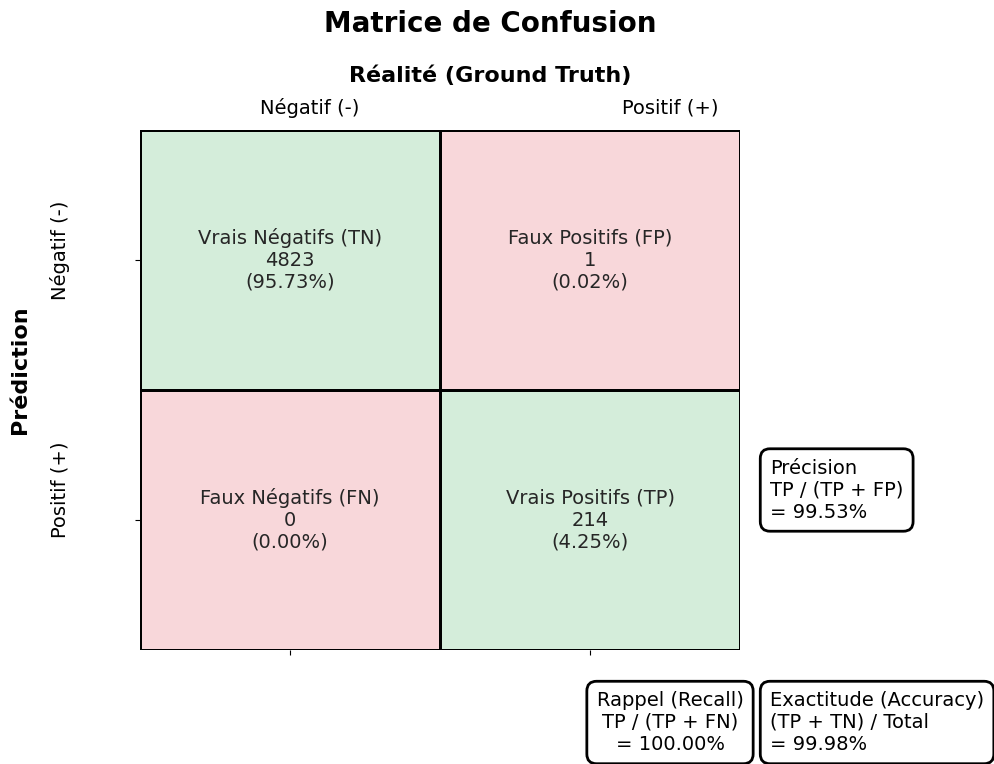

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap


model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix_custom(conf_matrix, title="Matrice de Confusion"):
    """
    Affiche une matrice de confusion stylisée avec métriques.
    """
    # Extraction des valeurs
    tn, fp, fn, tp = conf_matrix.ravel()
    
    # Calcul des métriques
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    
    # Préparation des labels
    group_names = ['Vrais Négatifs (TN)', 'Faux Positifs (FP)', 
                   'Faux Négatifs (FN)', 'Vrais Positifs (TP)']
    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f"{v1}\n{v2}\n({v3})" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    # Masque de couleur
    color_mask = np.array([[0, 1], [1, 0]])
    cmap = ListedColormap(['#d4edda', '#f8d7da'])
    
    # Création du Graphique
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Affichage de la heatmap
    sns.heatmap(color_mask, annot=labels, fmt='', cmap=cmap, cbar=False,
                linewidths=2, linecolor='black', annot_kws={"fontsize":14}, ax=ax)
    
    # Suppression des labels d'axes par défaut
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # --- MODIFICATIONS DE POSITIONNEMENT ---
    
    # 1. Ajustement des marges pour laisser de la place au titre
    # 'top=0.80' descend le graphique pour libérer l'espace en haut
    plt.subplots_adjust(left=0.15, right=0.75, top=0.80, bottom=0.15)

    # 2. Axe X (Haut) - Réalité
    # On descend ces textes (y=0.86 et y=0.82) pour qu'ils soient sous le titre principal
    fig.text(0.5, 0.86, 'Réalité (Ground Truth)', ha='center', fontsize=16, fontweight='bold')
    fig.text(0.32, 0.82, 'Négatif (-)', ha='center', fontsize=14)
    fig.text(0.68, 0.82, 'Positif (+)', ha='center', fontsize=14)
    
    # Axe Y (Gauche) - Prédiction
    fig.text(0.02, 0.5, 'Prédiction', va='center', rotation=90, fontsize=16, fontweight='bold')
    fig.text(0.06, 0.65, 'Négatif (-)', va='center', rotation=90, fontsize=14)
    fig.text(0.06, 0.35, 'Positif (+)', va='center', rotation=90, fontsize=14)
    
    # Style des boîtes
    box_style = dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', linewidth=2)
    
    # Boîte de Précision (À droite)
    fig.text(0.78, 0.35, f"Précision\nTP / (TP + FP)\n= {precision:.2%}",
             ha='left', va='center', fontsize=14, bbox=box_style)
    
    # Boîte de Rappel (En bas)
    fig.text(0.68, 0.02, f"Rappel (Recall)\nTP / (TP + FN)\n= {recall:.2%}",
             ha='center', va='bottom', fontsize=14, bbox=box_style)
    
    # Boîte d'Exactitude (En bas à droite)
    fig.text(0.78, 0.02, f"Exactitude (Accuracy)\n(TP + TN) / Total\n= {accuracy:.2%}",
             ha='left', va='bottom', fontsize=14, bbox=box_style)
    
    # Titre principal
    fig.suptitle(title, fontsize=20, fontweight='bold', y=0.95)
    
    plt.show()
plot_confusion_matrix_custom(conf_matrix)

### Tentative sans la colonne moid


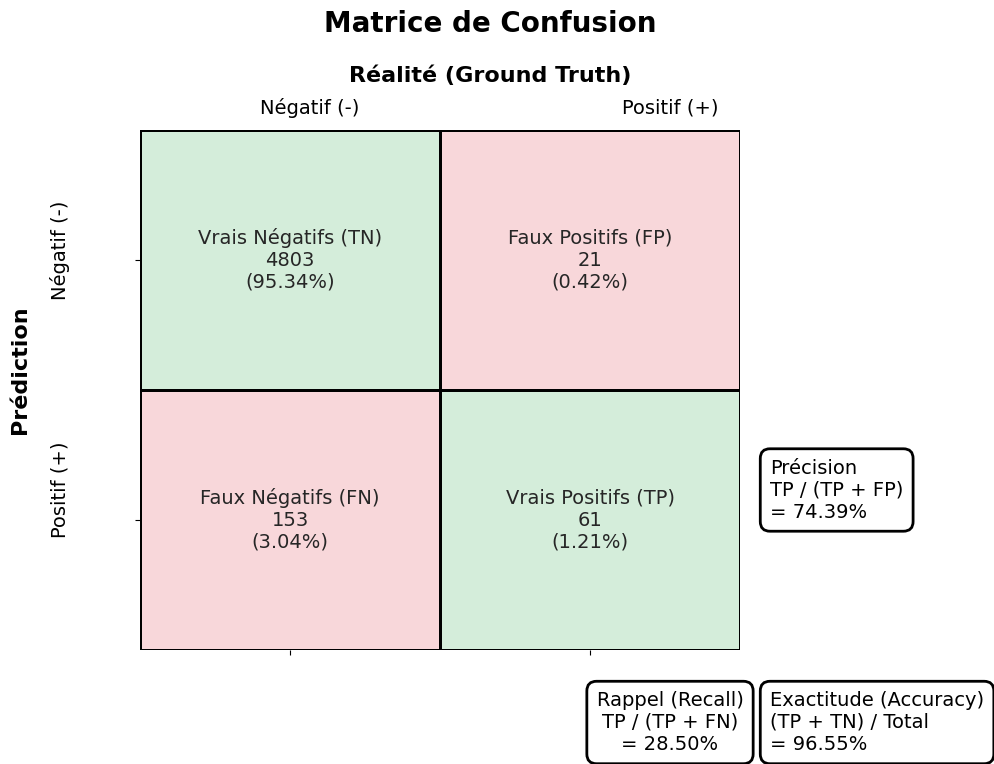

In [44]:
X = df.drop(['is_hazardous','id','name','moid'], axis=1) 
y = df['is_hazardous']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# On normalise les données numériques
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix_custom(conf_matrix)


### 3eme essai en utilisant le SMOTE

Taille avant SMOTE : {0: 19296, 1: 855}
Taille après SMOTE : {0: 19296, 1: 19296}


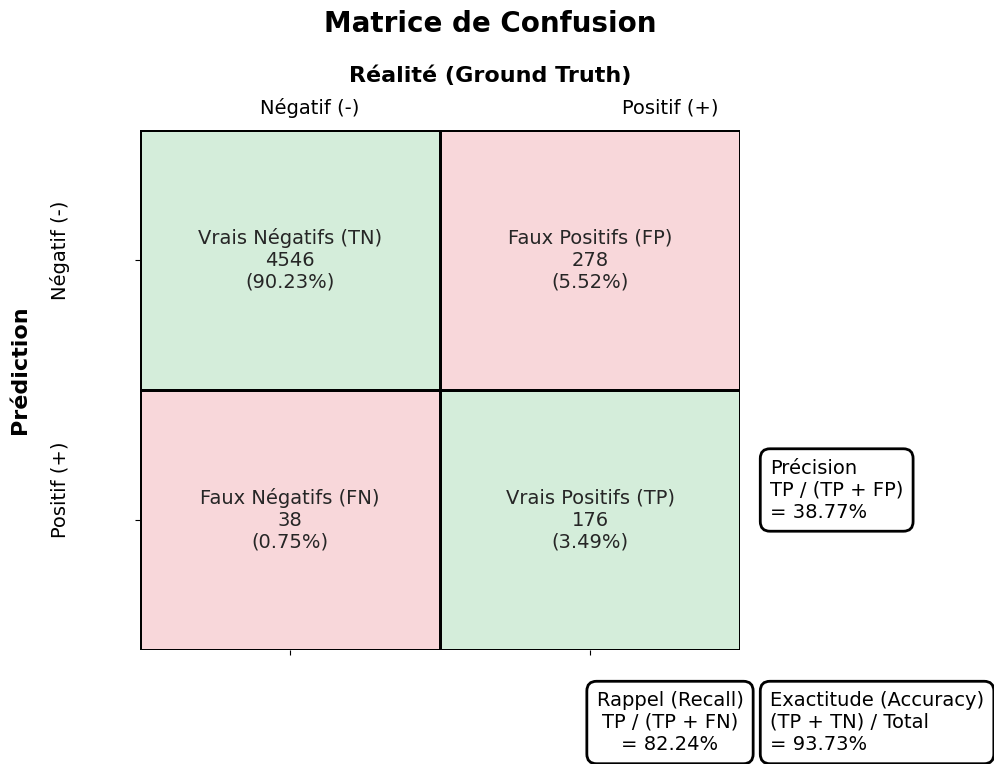

In [45]:
# 1. Importation de SMOTE
from imblearn.over_sampling import SMOTE 

# Tes données
X = df.drop(['is_hazardous','id','name','moid'], axis=1) 
y = df['is_hazardous']

# 2. Le Split (Toujours en premier !)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. La Normalisation
scaler = StandardScaler()

# On fit sur le train uniquement
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # On transforme le test avec les stats du train

# --- 4. C'EST ICI QU'ON APPLIQUE SMOTE ---
print("Taille avant SMOTE :", y_train.value_counts().to_dict())

smote = SMOTE(random_state=42)
# On crée les données synthétiques (X_resampled, y_resampled)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Taille après SMOTE :", y_train_resampled.value_counts().to_dict())
# Tu devrais voir qu'il y a maintenant autant de 0 que de 1 (50/50)

# 5. Entraînement du modèle
# Note : J'ai enlevé "class_weight='balanced'" car SMOTE a déjà équilibré les données !
model = RandomForestClassifier(n_estimators=100, random_state=42)

# IMPORTANT : On entraîne sur les données "resampled" (avec les faux astéroïdes)
model.fit(X_train_resampled, y_train_resampled)

# 6. Prédiction 
# IMPORTANT : On prédit sur le X_test ORIGINAL (sans fake data)
y_pred = model.predict(X_test_scaled)

# 7. Affichage
conf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix_custom(conf_matrix)


### 4eme essai avec parametre opti

In [46]:
from sklearn.model_selection import GridSearchCV

# On définit une "grille" de paramètres à tester
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

# On configure le chercheur
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,                 # Validation croisée en 3 parties
    scoring='recall',     # IMPORTANT : On dit à l'IA "Maximise le RECALL (Sécurité)" !
    n_jobs=-1,            # Utilise tous les cœurs du CPU
    verbose=2
)

# On lance la recherche (sur les données SMOTE)
print("Recherche des meilleurs paramètres en cours...")
grid_search.fit(X_train_resampled, y_train_resampled)

print(f"Meilleurs paramètres trouvés : {grid_search.best_params_}")

# Le meilleur modèle est déjà prêt à l'emploi
best_model = grid_search.best_estimator_

Recherche des meilleurs paramètres en cours...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Meilleurs paramètres trouvés : {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}


Taille avant SMOTE : {0: 19296, 1: 855}
Taille après SMOTE : {0: 19296, 1: 19296}


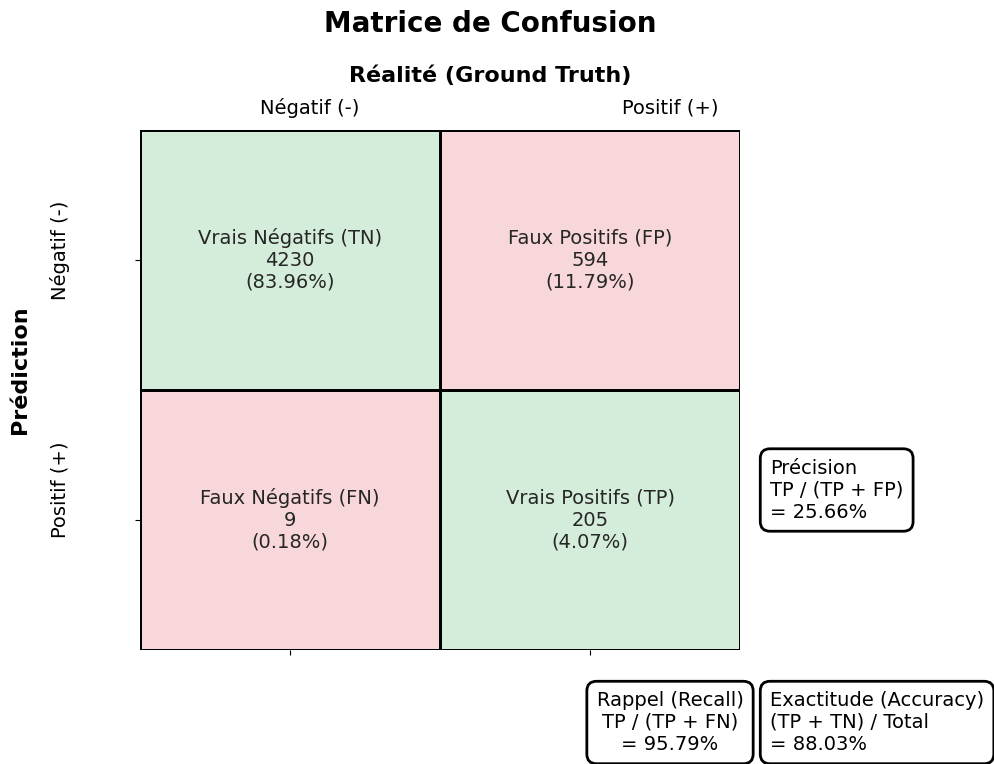

In [53]:
# 1. Importation de SMOTE
from imblearn.over_sampling import SMOTE 

# Tes données
X = df.drop(['is_hazardous','id','name','moid'], axis=1) 
y = df['is_hazardous']

# 2. Le Split (Toujours en premier !)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. La Normalisation
scaler = StandardScaler()

# On fit sur le train uniquement
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # On transforme le test avec les stats du train

# --- 4. C'EST ICI QU'ON APPLIQUE SMOTE ---
print("Taille avant SMOTE :", y_train.value_counts().to_dict())

smote = SMOTE(random_state=42)
# On crée les données synthétiques (X_resampled, y_resampled)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Taille après SMOTE :", y_train_resampled.value_counts().to_dict())
# Tu devrais voir qu'il y a maintenant autant de 0 que de 1 (50/50)

# 5. Entraînement du modèle
# Note : J'ai enlevé "class_weight='balanced'" car SMOTE a déjà équilibré les données !
model = RandomForestClassifier(n_estimators=100, random_state=42,min_samples_leaf=1,max_depth=10)

# IMPORTANT : On entraîne sur les données "resampled" (avec les faux astéroïdes)
model.fit(X_train_resampled, y_train_resampled)

# 6. Prédiction 
# IMPORTANT : On prédit sur le X_test ORIGINAL (sans fake data)
y_pred = model.predict(X_test_scaled)

# 7. Affichage
conf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix_custom(conf_matrix)


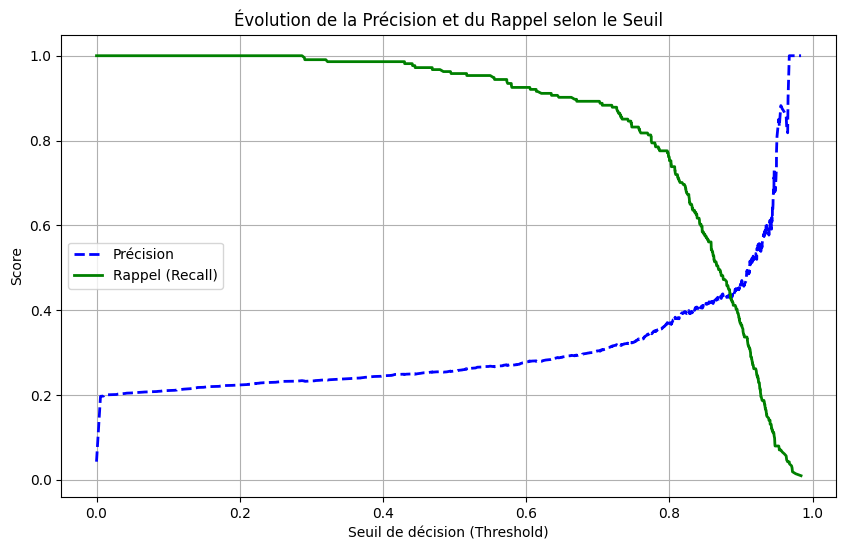

In [54]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# 1. Obtenir les probabilités brutes (pas les 0/1)
# On prend la colonne 1 qui correspond à la probabilité d'être "Dangereux"
y_scores = model.predict_proba(X_test_scaled)[:, 1]

# 2. Calculer les points de la courbe
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# 3. Afficher la courbe
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Précision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Rappel (Recall)", linewidth=2)
plt.xlabel("Seuil de décision (Threshold)")
plt.ylabel("Score")
plt.legend(loc="center left")
plt.title("Évolution de la Précision et du Rappel selon le Seuil")
plt.grid(True)
plt.show()

In [55]:
import numpy as np
from sklearn.metrics import fbeta_score

# 1. On teste tous les seuils possibles de la courbe
f2_scores = []
# On parcourt les seuils calculés par precision_recall_curve
for t in thresholds:
    # On crée des prédictions temporaires pour ce seuil t
    y_pred_temp = (y_scores >= t).astype(int)
    # On calcule le F2 (beta=2 privilégie le rappel)
    score = fbeta_score(y_test, y_pred_temp, beta=2)
    f2_scores.append(score)

# 2. On trouve l'index du meilleur score
best_idx = np.argmax(f2_scores)
best_threshold = thresholds[best_idx]
best_f2 = f2_scores[best_idx]

print(f"--- RÉSULTAT OPTIMISATION ---")
print(f"Le seuil parfait pour la sécurité (F2-Score) est : {best_threshold:.4f}")
print(f"Meilleur F2-Score obtenu : {best_f2:.4f}")

# 3. On regarde ce que ça donne en Précision/Rappel à ce seuil précis
print(f"Précision à ce seuil : {precisions[best_idx]:.4f}")
print(f"Rappel à ce seuil    : {recalls[best_idx]:.4f}")

--- RÉSULTAT OPTIMISATION ---
Le seuil parfait pour la sécurité (F2-Score) est : 0.7264
Meilleur F2-Score obtenu : 0.6501
Précision à ce seuil : 0.3186
Rappel à ce seuil    : 0.8785


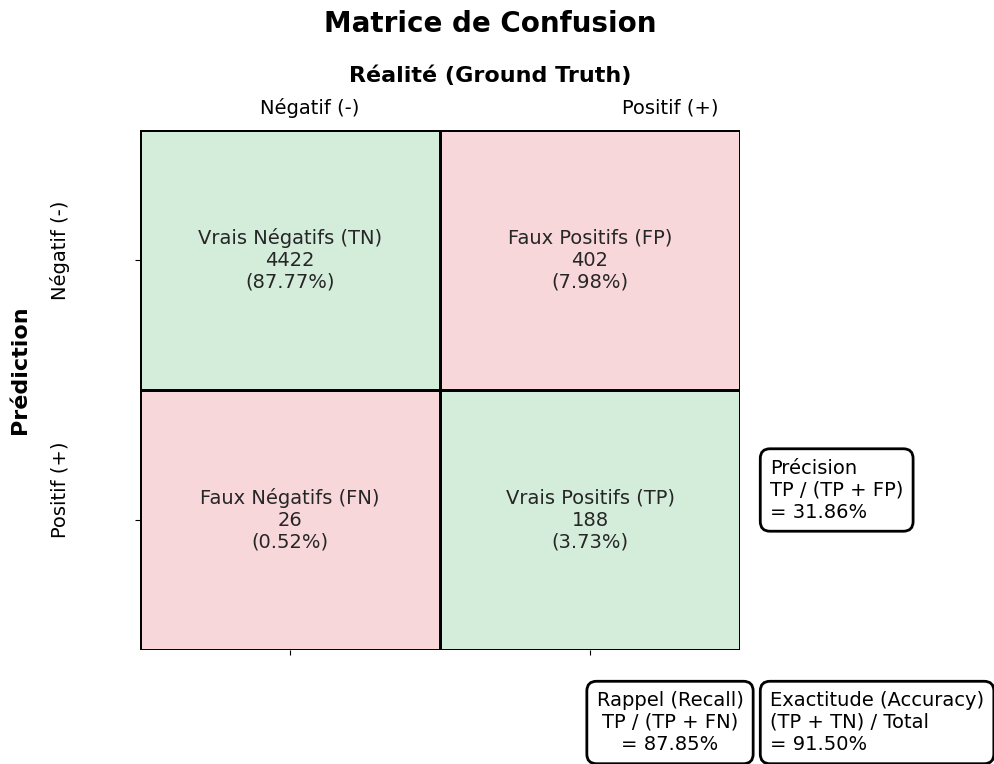

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      4824
           1       0.32      0.88      0.47       214

    accuracy                           0.92      5038
   macro avg       0.66      0.90      0.71      5038
weighted avg       0.97      0.92      0.93      5038



In [56]:
# Application du seuil optimisé
y_pred_final = (y_scores >= best_threshold).astype(int)

# Affichage avec ta fonction personnalisée
conf_matrix_final = confusion_matrix(y_test, y_pred_final)
plot_confusion_matrix_custom(conf_matrix_final)

print(classification_report(y_test, y_pred_final))

### Calcul energie cinétique

Nouvelles colonnes physiques créées !
Entraînement avec la physique...
--- RÉSULTATS AVEC ÉNERGIE CINÉTIQUE ---
              precision    recall  f1-score   support

           0       1.00      0.88      0.94      4824
           1       0.26      0.95      0.41       214

    accuracy                           0.88      5038
   macro avg       0.63      0.92      0.67      5038
weighted avg       0.97      0.88      0.91      5038



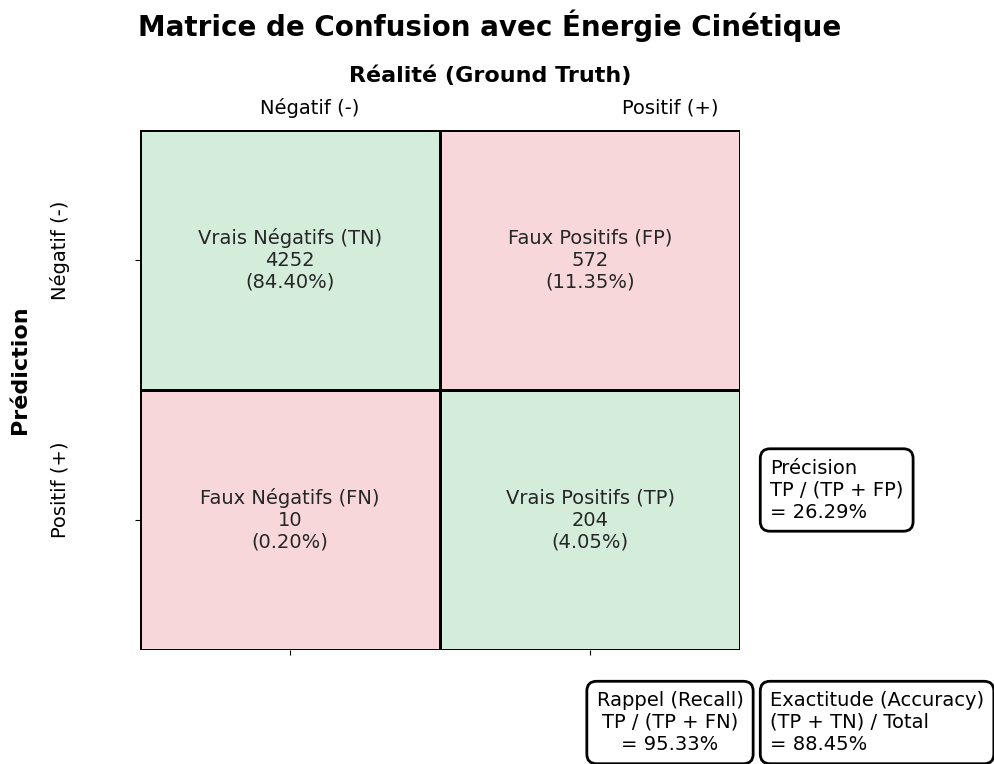

In [58]:
# 1. Création de la Feature Physique (Avant de séparer X et y)
# Formule E_c = 1/2 * mv^2
# On approxime la masse par le volume (Diamètre^3)
# On ne cherche pas la valeur exacte en Joules, juste une valeur proportionnelle pour l'IA
df['kinetic_energy'] = (df['diameter_max_km']**3) * (df['velocity_kph']**2)

# Optionnel : On peut aussi ajouter le "Momentum" (Quantité de mouvement)
df['momentum'] = (df['diameter_max_km']**3) * df['velocity_kph']

print("Nouvelles colonnes physiques créées !")

# 2. Définition des variables (On inclut les nouvelles colonnes)
# On enlève 'moid' (triche), 'id', 'name', 'is_hazardous'
cols_to_drop = ['is_hazardous', 'id', 'name', 'moid']
X = df.drop(cols_to_drop, axis=1)
y = df['is_hazardous']

# 3. Le Split Stratifié
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. La Normalisation (Indispensable pour l'énergie cinétique qui a des valeurs énormes)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Le SMOTE (Pour l'équilibre)
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# 6. Entraînement du Random Forest (Avec tes meilleurs paramètres)
from sklearn.ensemble import RandomForestClassifier
model_physique = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    min_samples_leaf=1, 
    random_state=42
)

print("Entraînement avec la physique...")
model_physique.fit(X_train_resampled, y_train_resampled)

# 7. Résultats
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model_physique.predict(X_test_scaled)

print("--- RÉSULTATS AVEC ÉNERGIE CINÉTIQUE ---")
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix_custom(conf_matrix, title="Matrice de Confusion avec Énergie Cinétique")

### test de la calibration 


In [ ]:
from sklearn.calibration import CalibrationDisplay

plt.figure(figsize=(8, 6))
# On compare tes 2 champions : Random Forest et LogReg
CalibrationDisplay.from_estimator(model, X_test_scaled, y_test, n_bins=10, name='Random Forest')

plt.plot([0, 1], [0, 1], linestyle='--', label='Parfaitement Calibré')
plt.title("Courbe de Calibration (Fiabilité des probabilités)")
plt.show()

ValueError: X has 10 features, but RandomForestClassifier is expecting 8 features as input.

<Figure size 800x600 with 0 Axes>

## Essai avec La Régression Logistique

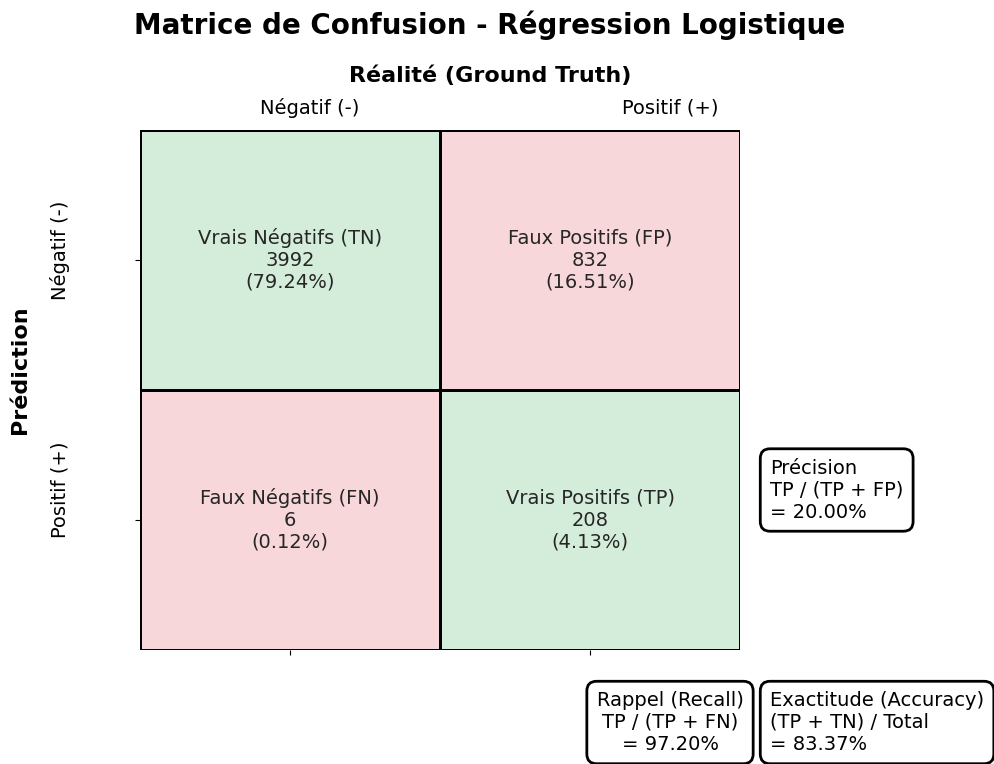

In [49]:
from sklearn.linear_model import LogisticRegression

# On utilise les mêmes données préparées que pour SMOTE
# X_train_resampled, y_train_resampled, X_test_scaled, y_test

# 1. Créer et entraîner le modèle de Régression Logistique
log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)
log_reg.fit(X_train_resampled, y_train_resampled)

# 2. Prédiction
y_pred_log = log_reg.predict(X_test_scaled)

# 3. Matrice de confusion
conf_matrix_log = confusion_matrix(y_test, y_pred_log)

plot_confusion_matrix_custom(conf_matrix_log, title="Matrice de Confusion - Régression Logistique")


## Essai avec KNN

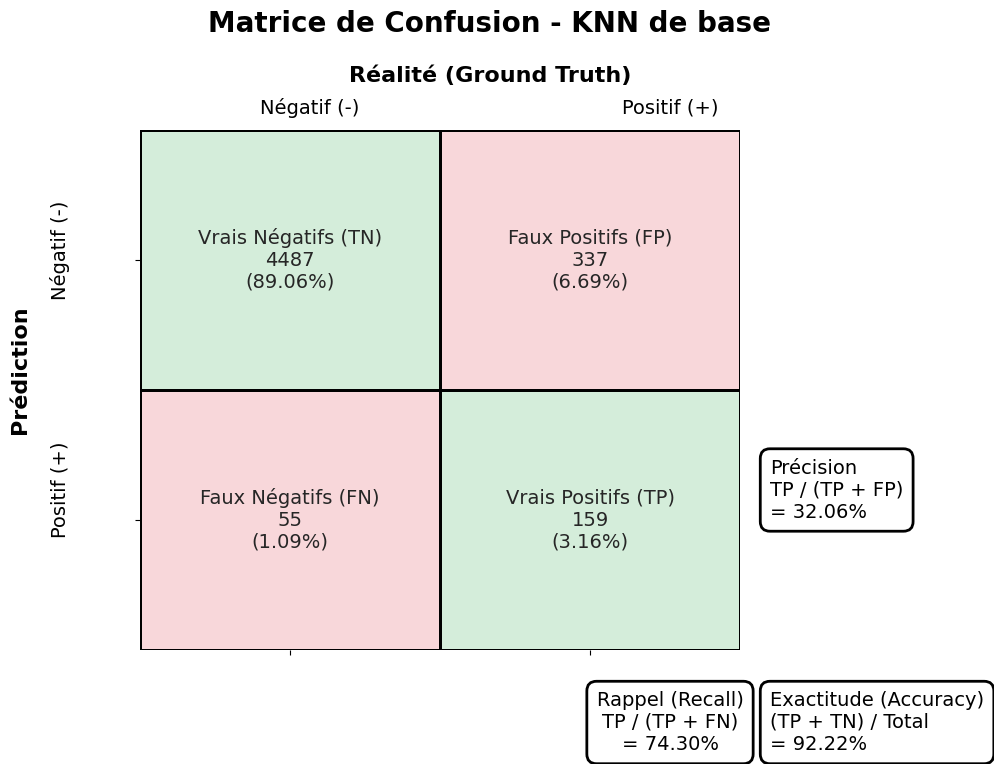

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


# 1. Modèle KNN de base
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train_resampled, y_train_resampled)

y_pred_knn = knn.predict(X_test_scaled)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

plot_confusion_matrix_custom(conf_matrix_knn, title="Matrice de Confusion - KNN de base")




Recherche des meilleurs paramètres pour KNN...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Meilleurs paramètres KNN : {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}


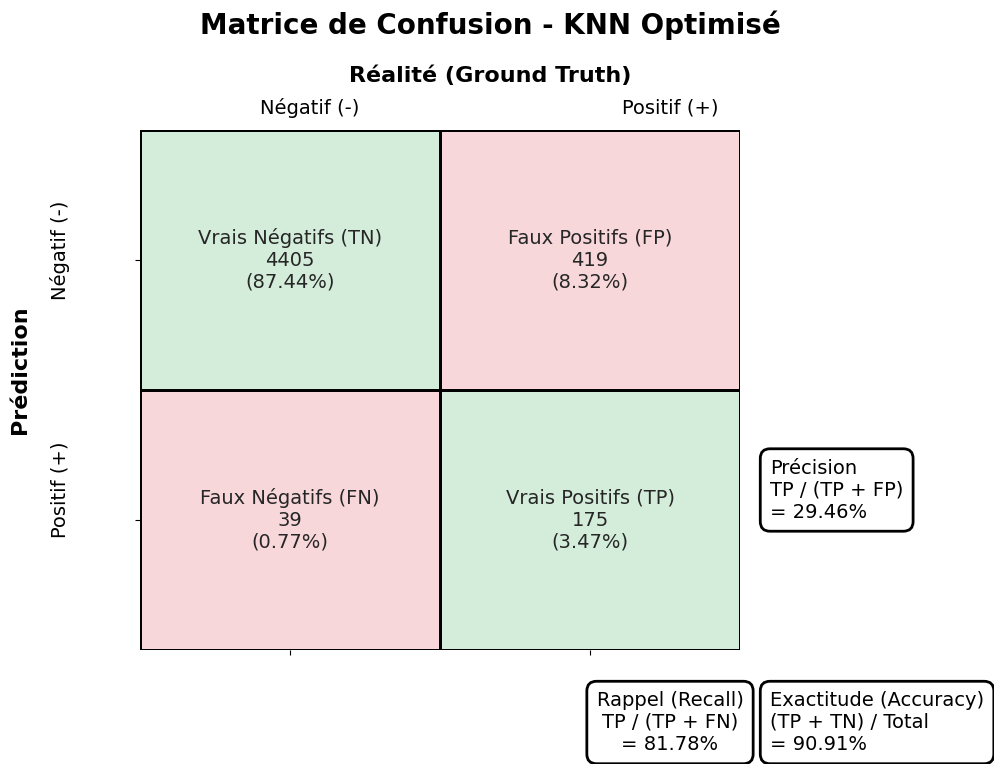

In [51]:
# 2. Optimisation KNN avec GridSearchCV
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_knn,
    cv=3,
    scoring='recall',   # On maximise le recall sur la classe dangereuse
    n_jobs=-1,
    verbose=1
)

print("\nRecherche des meilleurs paramètres pour KNN...")
grid_knn.fit(X_train_resampled, y_train_resampled)
print("Meilleurs paramètres KNN :", grid_knn.best_params_)

best_knn = grid_knn.best_estimator_

y_pred_knn_best = best_knn.predict(X_test_scaled)
conf_matrix_knn_best = confusion_matrix(y_test, y_pred_knn_best)

plot_confusion_matrix_custom(conf_matrix_knn_best, title="Matrice de Confusion - KNN Optimisé")


# Essai avec Naive Bayes

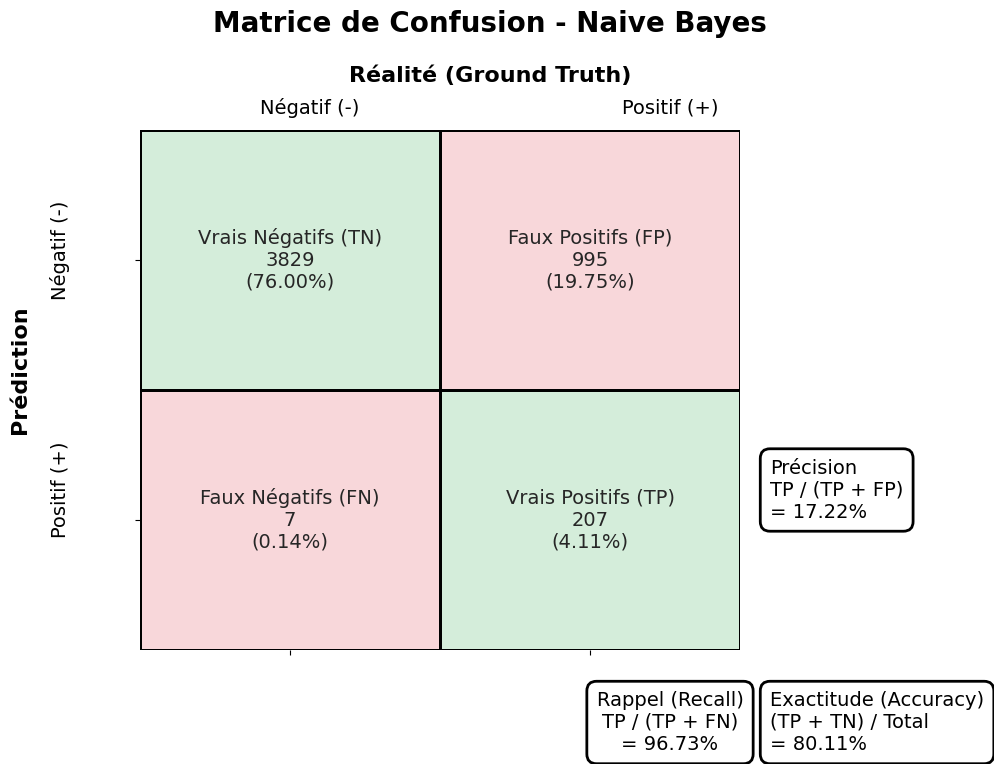

In [48]:
from sklearn.naive_bayes import GaussianNB

# On utilise les mêmes données préparées (avec SMOTE)
# X_train_resampled, y_train_resampled, X_test_scaled, y_test

# 1. Créer et entraîner le modèle Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_resampled, y_train_resampled)

# 2. Prédiction
y_pred_nb = nb_model.predict(X_test_scaled)

# 3. Matrice de confusion
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

plot_confusion_matrix_custom(conf_matrix_nb, title="Matrice de Confusion - Naive Bayes")